In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
def plot_the_loss_curve(epochs, mae_training, mae_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[1:], mae_training[1:], label="Training Loss")
  plt.plot(epochs[1:], mae_validation[1:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mae_lists = mae_training[1:] + mae_validation[1:]
  highest_loss = max(merged_mae_lists)
  lowest_loss = min(merged_mae_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [4]:
l_min = 1
l_max = 1

n_l = 1  # defined only one value for L, for now.

q_min = 10 * 10 ** 4
q_max = 100 * 10 ** 4

n_q = 5

E_min = 210 * 10 ** 9
E_max = 300 * 10 ** 9
n_E = 5

I_min = 1 * 10 ** (-5)
I_max = 10 * 10 ** (-5)

n_I = 5

# Will make the vectors linearly spaced, but it's not necessary
l_vec = np.linspace(l_min, l_max, n_l)
q_vec = np.linspace(q_min, q_max, n_q)
E_vec = np.linspace(E_min, E_max, n_E)
I_vec = np.linspace(I_min, I_max, n_I)

In [5]:
# Compute all possible permutations and arrange them in a matrix

per_list = []
for i in range(len(l_vec)):
    for j in range(len(q_vec)):
        for k in range(len(E_vec)):
            for l in range(len(I_vec)):
                per_list = np.append(per_list, np.array([[l_vec[i], q_vec[j], E_vec[k], I_vec[l]]]))

per_list = per_list.reshape(-1, 4)

# Shuffle the permutations
np.random.shuffle(per_list)

np.save('125_combinations', per_list)  # saved as an .npy file to use later using np.load('125_combinations')

In [6]:
# analytical solution for the beam bending problem

def ana_sol(n, l, q, E, I):
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * l ** 3) / (24 * E * I)
    y = (1 / (E * I)) * (((q * l) / 12) * x ** 3 - (q / 24) * x ** 4) + c_1 * x

    return [x, y]

def ana_sol_with_noise(n, param_list,noise):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * l ** 3) / (24 * E * I)
    y = (1 / (E * I)) * (((q * l) / 12) * x ** 3 - (q / 24) * x ** 4) + c_1 * x
    y = y + noise * (np.random.random(len(y)) - 0.5) * (np.max(y) - np.min(y))

    return [x, y]

In [7]:
#alternative way to generate fake data with noise
n = 1000
# Add noise
noise_factor = 0.2
#create dictionary with generated data
fake_data = {}
#dict keys: list of parameters values
#dict values: (x,y) array 
for i in per_list:
    fake_data[repr(i.tolist())] = ana_sol_with_noise(n, i, noise_factor)

In [8]:
#for each entry combination of (l,q,E,I) we have two columns of fake data: both x and noisy y 
fake_dataframe=pd.DataFrame.from_dict(fake_data,orient='index',columns=['x', 'y'])
#I will now dstructure the data in such a way that we are able to immediatly assess 
# which entry combination of (l,q,E,I) gives a specific (x,Y)
#let's clean a little
fake_dataframe=fake_dataframe.rename_axis('parameters').reset_index()
fake_dataframe.parameters=[eval(fake_dataframe.parameters[i]) for i in range(len(fake_dataframe))]
fake_dataframe[['l','q','E','I']] = pd.DataFrame(fake_dataframe.parameters.tolist(), index= fake_dataframe.index)
fake_dataframe=fake_dataframe.drop(columns='parameters')
#let's see an example of structured data
fake_dataframe

,x,y,l,q,E,I
0,"[0.0, 0.001001001001001001, 0.0020020020020020...","[0.00013451238206437988, 4.9755682304513446e-0...",1.0,325000.0,2.775000e+11,0.000010
1,"[0.0, 0.001001001001001001, 0.0020020020020020...","[9.810139495072157e-05, 0.0004097058877013989,...",1.0,1000000.0,3.000000e+11,0.000010
2,"[0.0, 0.001001001001001001, 0.0020020020020020...","[2.2304314541108175e-05, -6.34430518563096e-05...",1.0,550000.0,2.100000e+11,0.000055
3,"[0.0, 0.001001001001001001, 0.0020020020020020...","[2.4945159613077813e-05, -1.1524755338355856e-...",1.0,325000.0,2.100000e+11,0.000077
4,"[0.0, 0.001001001001001001, 0.0020020020020020...","[1.2913620792433909e-05, 5.95816651392349e-05,...",1.0,1000000.0,2.325000e+11,0.000077
...,...,...,...,...,...,...
120,"[0.0, 0.001001001001001001, 0.0020020020020020...","[3.5416041291682476e-06, -4.472799740289019e-0...",1.0,100000.0,3.000000e+11,0.000100
121,"[0.0, 0.001001001001001001, 0.0020020020020020...","[3.418501899980857e-06, 1.2233082625744945e-05...",1.0,325000.0,3.000000e+11,0.000100
122,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-1.8011296653376174e-05, 4.785212020260561e-0...",1.0,1000000.0,2.775000e+11,0.000077
123,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-3.906800551014844e-06, 2.367469409210811e-06...",1.0,100000.0,2.775000e+11,0.000077


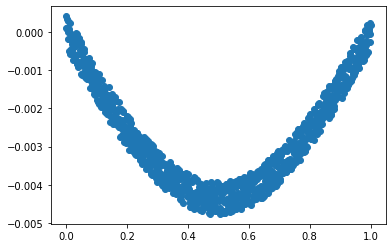

In [9]:
#plot the 1st entry of the dataframe
plt.scatter(fake_dataframe['x'][1],fake_dataframe['y'][1],label=str(fake_dataframe.index[1]))
plt.show()

In [10]:
#with the dataset organized is much easier to split the data.
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
#let's take a look at an example 
test_split=0.1 #we will use 10% of the data for testing. 
df = fake_dataframe
train_df, test_df = train_test_split(df, test_size = test_split)

In [11]:
#the training data will be spllited automatically by 80/20 during training using keras framework. 
# no need to split at this stage.
#let's check the array shapes: 
print('Training set: ',train_df.shape)
print('Test set: ',test_df.shape)

train_size = train_df.shape[0]
test_size = test_df.shape[0]

Training set:  (112, 6)
Test set:  (13, 6)


C:\Users\luisf\.conda\envs\tf\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


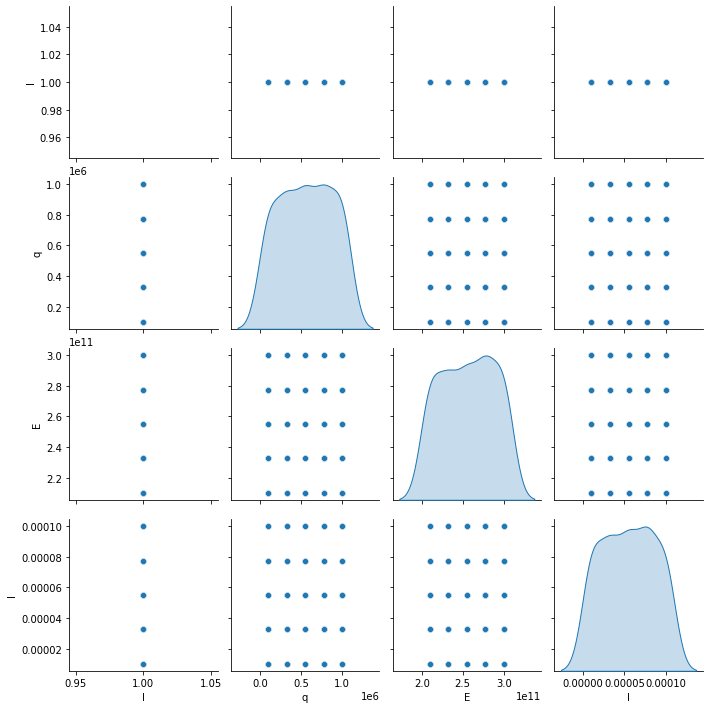

In [12]:
#inspect the training dataset
sns.pairplot(train_df[['l', 'q', 'E', 'I']], diag_kind='kde')

In [13]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
l,112.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
q,112.0,5.600446e+05,3.173202e+05,1.000000e+05,3.250000e+05,5.500000e+05,7.750000e+05,1.000000e+06
E,112.0,2.560045e+11,3.201819e+10,2.100000e+11,2.325000e+11,2.550000e+11,2.775000e+11,3.000000e+11
I,112.0,5.500000e-05,3.153184e-05,1.000000e-05,3.250000e-05,5.500000e-05,7.750000e-05,1.000000e-04


In [14]:
# follow this tutorial for our data 
# https://www.tensorflow.org/tutorials/keras/regression
# whenever possible, add comments and discussion

In [15]:
# get the max "y" for each entry
df.y.apply(min)
# at this point we could plot very interesting stuff such as ymax distributions on the vars (q,l,E,I)...
# but let's think about that later

0     -0.001670
1     -0.004761
2     -0.000680
3     -0.000285
4     -0.000793
         ...   
120   -0.000048
121   -0.000155
122   -0.000662
123   -0.000066
124   -0.000681
Name: y, Length: 125, dtype: float64

In [16]:
# I have fixed the value of L as 1.0 for now, so I am not using the values of [x,y] as inputs, only the values of y.

In [17]:
# Allocate the features and the labels in different DataFrames.

train_features = train_df.copy()
test_features = test_df.copy()

train_labels = pd.DataFrame([train_features.pop('l'), train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
train_labels = train_labels.T
test_labels = pd.DataFrame([test_features.pop('l'), test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
test_labels = test_labels.T

In [18]:
feature_columns = []
# x_col = tf.feature_column.numeric_column("x")
# feature_columns.append(x_col)
y_col = tf.feature_column.numeric_column("y")
feature_columns.append(y_col)

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [19]:
# Build the model and define its architecture.

In [20]:
inputs = keras.Input(shape=(1000))

In [21]:
dense = layers.Dense(256, activation="relu")
x = dense(inputs)

In [22]:
x = layers.Dense(256, activation="relu")(x)
outputs = layers.Dense(4)(x)

In [23]:
model = keras.Model(inputs=inputs, outputs=outputs, name="model")

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               256256    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 323,076
Trainable params: 323,076
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Set the hyperparameters

validation_split=0.2
learning_rate = 0.2
batch_size = 10
epochs = 100

In [35]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

# Still need to find what's the best loss function for our model.

In [36]:
# For some reason I had to manually convert the data into tensors.

tf_train_features = tf.constant([train_features['y']], shape=(train_size,n))

tf_train_labels = tf.constant([np.array(train_labels)], shape=(train_size,4))

tf_test_features = tf.constant([test_features['y']], shape=(test_size,n))

tf_test_labels = tf.constant([np.array(test_labels)], shape=(test_size,4))

In [37]:
history = model.fit(tf_train_features, tf_train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

test_scores = model.evaluate(tf_train_features, tf_train_labels, verbose=2)
print("Test loss:", test_scores)

Epoch 1/100
9/9 [==============================] - 1s 35ms/step - loss: 575901180049722703872.0000 - val_loss: 359595717668791910400.0000
Epoch 2/100
9/9 [==============================] - 0s 15ms/step - loss: 561858006433535098880.0000 - val_loss: 343953871738004045824.0000
Epoch 3/100
9/9 [==============================] - 0s 13ms/step - loss: 551343825337857343488.0000 - val_loss: 332823823393283375104.0000
Epoch 4/100
9/9 [==============================] - 0s 13ms/step - loss: 540417529691903098880.0000 - val_loss: 324296855633182851072.0000
Epoch 5/100
9/9 [==============================] - 0s 14ms/step - loss: 530413275700908785664.0000 - val_loss: 314344428222275387392.0000
Epoch 6/100
9/9 [==============================] - 0s 14ms/step - loss: 521620384456560869376.0000 - val_loss: 308461073443441344512.0000
Epoch 7/100
9/9 [==============================] - 0s 14ms/step - loss: 511122951121997398016.0000 - val_loss: 302128871629870071808.0000
Epoch 8/100
9/9 [=================

9/9 [==============================] - 0s 13ms/step - loss: 287508938194216288256.0000 - val_loss: 174049928703731826688.0000
Epoch 61/100
9/9 [==============================] - 0s 15ms/step - loss: 286654907930504069120.0000 - val_loss: 172033758629925486592.0000
Epoch 62/100
9/9 [==============================] - 0s 14ms/step - loss: 285317356433361076224.0000 - val_loss: 171633958609880088576.0000
Epoch 63/100
9/9 [==============================] - 0s 13ms/step - loss: 284655151366277169152.0000 - val_loss: 170817804322721497088.0000
Epoch 64/100
9/9 [==============================] - 0s 12ms/step - loss: 283540932670968037376.0000 - val_loss: 170802850964583743488.0000
Epoch 65/100
9/9 [==============================] - 0s 15ms/step - loss: 283132917100039897088.0000 - val_loss: 169936189511291633664.0000
Epoch 66/100
9/9 [==============================] - 0s 14ms/step - loss: 282421031699566559232.0000 - val_loss: 171606215732488044544.0000
Epoch 67/100
9/9 [======================

3.99546921264777e+20


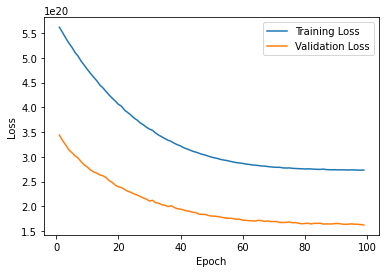

In [38]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [39]:
tf_test_labels

<tf.Tensor: shape=(13, 4), dtype=float64, numpy=
array([[1.000e+00, 3.250e+05, 2.325e+11, 1.000e-04],
       [1.000e+00, 1.000e+05, 2.550e+11, 1.000e-05],
       [1.000e+00, 1.000e+05, 2.550e+11, 5.500e-05],
       [1.000e+00, 1.000e+06, 2.775e+11, 1.000e-05],
       [1.000e+00, 5.500e+05, 2.325e+11, 1.000e-05],
       [1.000e+00, 7.750e+05, 2.100e+11, 3.250e-05],
       [1.000e+00, 1.000e+05, 2.325e+11, 7.750e-05],
       [1.000e+00, 1.000e+06, 2.550e+11, 3.250e-05],
       [1.000e+00, 7.750e+05, 3.000e+11, 1.000e-04],
       [1.000e+00, 3.250e+05, 2.100e+11, 5.500e-05],
       [1.000e+00, 3.250e+05, 3.000e+11, 3.250e-05],
       [1.000e+00, 1.000e+05, 2.100e+11, 1.000e-04],
       [1.000e+00, 5.500e+05, 2.325e+11, 1.000e-04]])>

In [40]:
model.predict(tf_test_features)

array([[6.4791737e+00, 5.2461850e+05, 2.5671464e+11, 1.4608860e-02],
       [7.9791737e+00, 5.2328047e+05, 2.5605551e+11, 1.2646089e+00],
       [5.4791737e+00, 5.2501050e+05, 2.5689811e+11, 1.5771089e+00],
       [1.1979174e+01, 5.0629647e+05, 2.4771428e+11, 9.3896084e+00],
       [1.1979174e+01, 5.1278847e+05, 2.5089517e+11, 5.9521089e+00],
       [9.4791737e+00, 5.1934647e+05, 2.5411715e+11, 3.0771089e+00],
       [3.4791739e+00, 5.2508250e+05, 2.5693559e+11, 2.5771089e+00],
       [9.9791737e+00, 5.1908247e+05, 2.5398867e+11, 4.8271089e+00],
       [5.4791737e+00, 5.2400647e+05, 2.5641250e+11, 1.7021089e+00],
       [5.4791737e+00, 5.2390047e+05, 2.5635462e+11, 1.5771089e+00],
       [8.9791737e+00, 5.2359447e+05, 2.5620962e+11, 1.9521089e+00],
       [4.9791737e+00, 5.2511650e+05, 2.5695512e+11, 7.6460886e-01],
       [5.9791737e+00, 5.2411847e+05, 2.5646504e+11, 1.5146089e+00]],
      dtype=float32)

In [41]:
# There is no point in trying to guess L in this case, as there is only one value for it.

# Even for multiple values of L, I think that it doesn't make sense to have [x, y] as inputs and at the same time try to 
# guess L, at least in the way I was innitially doing, because, (as the x values are linnearly spaced and allways the same
# for each L), we could easily check the max value of x and get L from that, without any need for a machine learning method.

In [42]:
# Need to improve the way I feed the data to the model (had to extract it from DataFrames and convert the arrays to tensors...)

# Will try to figure out the best loss function, the best architecture for the model,
# tune the hyperparameters and try to get good results.